In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/google_colab/music_cvae/music_cvae_notebook/

/content/drive/My Drive/google_colab/music_cvae/music_cvae_notebook


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import random as rand
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import FloatStorage, nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from chord_v2 import chord
from blstm_dataset_train import my_blstm_dataset as bdtrain
from blstm_dataset_test import my_blstm_dataset as bdtest

In [ ]:
BATCH_SIZE = 5
EPOCHS = 2000
SEQUENCE = 16
LIMIT = 50

decoders_initial_size = 32  #decoder input size

RANDOM_SEED = 1

cuda = not False and torch.cuda.is_available()

torch.manual_seed(RANDOM_SEED)

In [ ]:
train = bdtrain()
test = bdtrain()
train_loader = torch.utils.data.DataLoader(
    train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=False)

device = torch.device("cuda" if cuda else "cpu")

In [ ]:
class VAE(nn.Module):
    def __init__(self,teacher_forcing = False, scheduled_sampling = False):
        super(VAE, self).__init__()

        self.latent_dim = 128
        self.seq_dim = 16
        self.feature_dim = 12 + 2
        self.lstm_hidden_dim = 512
        self.input_dim = self.seq_dim*self.feature_dim
        self.fc0 = nn.Linear(self.input_dim, self.input_dim)
        self.fc_lstm1 = nn.LSTM(self.feature_dim ,self.lstm_hidden_dim,batch_first = True,bidirectional = True)
        self.fc1 = nn.Linear((16*self.lstm_hidden_dim*2), 150)
        self.fc21 = nn.Linear(self.lstm_hidden_dim*2, self.latent_dim)
        self.fc22 = nn.Linear(self.lstm_hidden_dim*2, self.latent_dim)
        self.fc3 = nn.Linear(self.latent_dim, 150)
        #self.fc4 = nn.Linear(150, self.input_dim)
        self.decoder = nn.LSTM(self.feature_dim + self.latent_dim,
                        self.latent_dim,
                        num_layers=1,
                        batch_first=True)
        #self.fc_lstm2 = nn.LSTM(self.feature_dim ,self.lstm_hidden_dim ,batch_first = True)
        #self.fc5 = nn.Linear(16*self.lstm_hidden_dim, self.input_dim)
        self.linear = nn.Linear(self.latent_dim, self.feature_dim)
        self.teacher_forcing = teacher_forcing
        self.scheduled_sampling = scheduled_sampling
    
    def prob(self, epoch, rate = 4):
        return 1/(np.exp((epoch/EPOCHS)*rate))

    def coinFlip(self, epoch):
        if self.prob(epoch) < rand.random():
            return True
        else:
            return False

    def encode(self, x):
        # print(x.view(-1, self.input_dim))
        h0 = F.relu(self.fc0(x.reshape(-1,self.input_dim)))
        h0 = h0.reshape(-1,self.seq_dim,self.feature_dim)
        f1_lstm_out, f1_lstm_h = self.fc_lstm1(h0)
        #f1_lstm_out = F.relu(f1_lstm_out)
        #print(f1_lstm_out.shape)
        #print(f1_lstm_h[1].shape)
        f1_lstm_h = torch.cat([f1_lstm_h[0][0],f1_lstm_h[0][0]],axis = 1)
        """
        h1 = F.relu(
            self.fc1(f1_lstm_out.reshape(-1, 16*self.lstm_hidden_dim*2)))
        """
        #h1 = F.relu(self.fc1(f1_lstm_h))

        return self.fc21(f1_lstm_h), self.fc22(f1_lstm_h)

    def decode(self, latent,x,epoch):
        """
        h3 = F.relu(
            self.fc3(latent))
        h4 = F.relu(self.fc4(h3))        
        h4 = torch.t(h4).reshape(-1, self.seq_dim, self.feature_dim)
        h5, h5_c = self.fc_lstm2(h4)
        h5 = h5.reshape(-1,16*self.lstm_hidden_dim)
        h5 = self.fc5(h5)
        """
        BATCH_SIZE = x.size()[0]
        latent = torch.reshape(latent,(BATCH_SIZE,1,-1))
        decoder_hidden = (torch.zeros(1,
                                BATCH_SIZE,
                                self.latent_dim,
                                device=device),
                          torch.zeros(1,
                                BATCH_SIZE,
                                self.latent_dim,
                                device=device))
        note = torch.rand(BATCH_SIZE, 1, self.feature_dim, device=device)
        notes = torch.zeros(BATCH_SIZE,16,self.feature_dim, device=device)
        counter = 0

        """
        Todo 入力データの場合分けを行う。(Scheduled Sampling)
            データの入力表現が合っているか確認。
            ネットワークの一部を切り取って確認。
            小さい動く部品から組み立てていく。
        """
        if self.scheduled_sampling:
            self.teacher_forcing = self.coinFlip(epoch)

        for i in range(SEQUENCE):
            #print(latent.shape,note.shape)

            e = torch.cat([latent, note], dim=-1)
            e = e.view(BATCH_SIZE, 1, -1)

            # Generate a single note (for each batch)
            note, decoder_hidden = self.decoder(e, decoder_hidden)

            aux = self.linear(note)
            # aux = torch.relu(aux)
            # aux = torch.sigmoid(aux)

            notes[:, counter, :] = aux.squeeze()

            """
            note = x[:,counter,:]
            note = torch.reshape(note, (BATCH_SIZE,1,self.feature_dim))
            """
            if self.teacher_forcing:
                note = x[:,i,:].reshape(BATCH_SIZE,1,-1)
            else:
                note = aux
            #print(note.shape)
            counter = counter + 1

        #recon_x = h5.reshape(-1, self.seq_dim, self.feature_dim)
        #recon_x = F.softmax(recon_x,dim=2)
        #print(h5.shape)
        notes = F.softmax(notes ,dim=2)

        return notes
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, epoch):
        x = x.float()

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu,logvar)
        return self.decode(z,x,epoch),mu, logvar

In [ ]:
model = VAE(teacher_forcing=True,scheduled_sampling=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    cd = chord()
    BCE = F.binary_cross_entropy(
        recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    """ConsonanseLoss = F.binary_cross_entropy(cd.loss_exam(recon_x, labels),
                                            cd.loss_exam(x[0], labels).float().detach())"""
                              
    """
    ConsonanseLoss = torch.zeros(1, requires_grad=True)

    for i, (melody_i, chord_i, chord_type_i, consonance_i) in enumerate(zip(x, chord_d, chord_type, consonance)):
        ConsonanseLoss = ConsonanseLoss + (
            consonance_i - cd.calc_consonance_loss(melody_i, chord_i, chord_type_i).detach())**2

    # ConsonanseLoss = ConsonanseLoss.sum()
    ConsonanseLoss = BCE.item()/10*ConsonanseLoss
    """
    #print(BCE)
    return BCE + KLD


In [ ]:
def show_params(net):
    for n in net.parameters():
        print(n)

def show_weights(net):
    print(net.decoder.weight.grad)


In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    train_consonanse_loss = 0
    cnt = 1
    for batch_idx, (melody, chord_d, chord_type) in enumerate(train_loader):
        # print(data.size(), labels.size())
        # print(labels)
        melody = melody.to(device)
        chord_d = chord_d.to(device)
        chord_type = chord_type.to(device)
        optimizer.zero_grad()
        recon_batch ,mu, logvar= model(melody,epoch)
        loss = loss_function(
            recon_batch, melody, mu, logvar)
        loss.backward()
        train_loss += loss.item()

        #ネットワークパラメータを表示
        #show_params(model)
        #show_weights(model)

        #train_consonanse_loss += consonanse_loss.item()
        optimizer.step()

        if cnt % (100) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(melody), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(melody)))
        cnt += 1
        if batch_idx*BATCH_SIZE >= LIMIT: 
            break

    print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))
    return train_loss/BATCH_SIZE, train_consonanse_loss

In [ ]:
def out_test():
    model.eval()
    model.teacher_forcing = False
    model.scheduled_sampling = False
    test_loss = 0
    label_flag = True
    with torch.no_grad():
        for batch_idx, (melody, chord_d, chord_type) in enumerate(test_loader):
            # print(data.size(), labels.size())
            # print(labels)
            melody = melody.to(device)
            chord_d = chord_d.to(device)
            chord_type = chord_type.to(device)
            optimizer.zero_grad()
            mu, logvar = model.encode(melody)
            z = model.reparameterize(mu, logvar)
            output = model.decode(z,melody,0)

            melody = melody.to('cpu').detach().numpy().copy()
            output = output.to('cpu').detach().numpy().copy()
            melody_1 = pd.DataFrame(
                melody[0],
                columns=['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b', 'rest','hold'])
            output_1 = pd.DataFrame(
                output[0],
                columns=['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b', 'rest','hold'])
            print(z)
            print(melody_1)
            print(output_1.round(1))
            #output.to_csv('test_out.csv')
            return melody_1.values,output_1.round(1).values

====> Epoch: 1 Average loss: 0.1354
====> Epoch: 2 Average loss: 0.0842
====> Epoch: 3 Average loss: 0.0795
====> Epoch: 4 Average loss: 0.0794
====> Epoch: 5 Average loss: 0.0787
====> Epoch: 6 Average loss: 0.0737
====> Epoch: 7 Average loss: 0.0750
====> Epoch: 8 Average loss: 0.0711
====> Epoch: 9 Average loss: 0.0708
====> Epoch: 10 Average loss: 0.0703
====> Epoch: 11 Average loss: 0.0699
====> Epoch: 12 Average loss: 0.0697
====> Epoch: 13 Average loss: 0.0689
====> Epoch: 14 Average loss: 0.0693
====> Epoch: 15 Average loss: 0.0686
====> Epoch: 16 Average loss: 0.0686
====> Epoch: 17 Average loss: 0.0681
====> Epoch: 18 Average loss: 0.0682
====> Epoch: 19 Average loss: 0.0681
====> Epoch: 20 Average loss: 0.0676
====> Epoch: 21 Average loss: 0.0673
====> Epoch: 22 Average loss: 0.0662
====> Epoch: 23 Average loss: 0.0587
====> Epoch: 24 Average loss: 0.0554
====> Epoch: 25 Average loss: 0.0583
====> Epoch: 26 Average loss: 0.0561
====> Epoch: 27 Average loss: 0.0548
====> Epoc

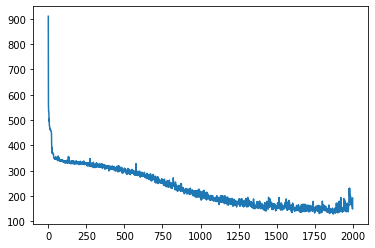

In [ ]:
if __name__ == "__main__":
    train_flag = True
    model_path = 'models/lstm_cvae_16_noc_f.pth'

    loss_array = np.ndarray(0)
    consonanse_array = np.ndarray(0)
    epoch_array = np.arange(1, EPOCHS+1)

    if train_flag:
        for epoch in range(1, EPOCHS + 1):
            train_loss, train_consonanse_loss = train(epoch)
            loss_array = np.append(loss_array, train_loss)
            # consonanse_array = np.append(consonanse_array, train_consonanse_loss)
            # test(epoch)
        torch.save(model.to('cpu').state_dict(), model_path)
        plt.plot(np.arange(len(loss_array)),loss_array)
        # plt.ylim(0,1000)
        plt.show()
    else:
        model.load_state_dict(torch.load(model_path))
        out_test()

In [ ]:
model.load_state_dict(torch.load(model_path))
input,output = out_test()

tensor([[-0.6810,  0.6958, -0.3345,  0.7204, -0.5109, -0.1972,  0.4285, -0.5568,
         -1.7098,  1.1350,  1.3982,  0.0228,  1.3285, -1.6573,  0.3988,  0.5236,
         -1.2412,  0.6757, -1.8348, -0.0974,  1.0441, -0.5296, -0.1860, -0.1364,
          0.5409, -1.6729,  0.0490,  0.0356,  0.8779, -0.7492,  0.6301,  0.6726,
         -0.3850,  0.0987, -1.0679, -2.1698,  0.9807,  0.5303, -0.5011,  0.2484,
          0.5562,  0.2637, -0.8408, -1.6059,  0.6314, -0.0538,  0.1430, -0.4364,
          0.4180,  0.2277, -1.9175, -1.1202, -0.7235,  1.3101, -1.7007,  0.4678,
         -1.8214, -1.8990, -0.4621,  1.0696,  0.2363,  0.4450,  0.0924, -2.1672,
         -0.7590,  1.2519,  0.2167, -0.8790, -0.3262,  0.8644,  0.4979, -1.8266,
          0.4804, -0.4069,  1.8688,  0.4476, -2.1389, -0.0519, -0.3718,  1.8231,
          0.8069, -0.5112,  1.3761,  1.0974, -1.3368, -0.7806,  1.5306, -1.0720,
         -0.6187,  0.9772, -1.2359, -0.3297,  0.0315, -0.2014,  0.8892, -0.2986,
          0.9221,  0.8039,  

In [ ]:
np.round(100.0*(input.size - np.abs(input - output).sum())/input.size,4)

96.875